# ENHANCE! 

## Super Resolution with OpenVINO

WORK IN PROGRESS NOTEBOOK NOT READY AND FOR PUBLIC RELEASE

[Super Resolution Model description](https://github.com/openvinotoolkit/open_model_zoo/blob/develop/models/intel/single-image-super-resolution-1032/description/single-image-super-resolution-1032.md)

## Preparation

### Install requirements

Uncomment the cell below to install the Python packages that are required to run this notebook. 

In [1]:
# ! pip install --quiet --index-url https://test.pypi.org/simple --extra-index-url https://pypi.org/simple openvino-dev
# ! pip install matplotlib youtube_dl Pillow

### Imports

In [2]:
import os
import time
import urllib
from base64 import b64encode
from pathlib import Path, PurePosixPath

import cv2
import matplotlib.pyplot as plt
import numpy as np
import youtube_dl
from IPython.display import HTML
from IPython.display import Image as DisplayImage
from openvino.inference_engine import IECore
from PIL import Image

### Settings

In [3]:
model_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/single-image-super-resolution-1032/FP16/single-image-super-resolution-1032.xml"
device = "CPU"

model_name = os.path.basename(model_url)
model_xml = f"models/{model_name}"

### Functions


In [4]:
# TODO: clean up, add comments and make more robust!
def resize_and_pad(image, input_shape, interpolation=cv2.INTER_LINEAR):
    """
    Resize image to input_shape (width, height), preserving aspect ratio, adding padding where necessary
    cv2.INTER_LINEAR is the default interpolation of cv2.resize
    """
    if image.shape[:2] == input_shape[::-1]:
        return image
    else:
        target_width, target_height = input_shape
        height_multi = target_height / image.shape[0]
        width_multi = target_width / image.shape[1]
        multi = min(width_multi, height_multi)
        multi_dimension = np.argmin((height_multi, width_multi))
        new_target_width = int(round(image.shape[1] * multi))
        new_target_height = int(round(image.shape[0] * multi))

        resized_image = cv2.resize(image, (new_target_width, new_target_height), interpolation=interpolation)
        if target_width / target_height != image.shape[2] / image.shape[1]:
            # Aspect ratio of image is not the same as aspect ratio of target: add padding
            if multi_dimension == 0:  # pad width
                index = (target_width - resized_image.shape[1]) // 2
                pad = ((0, 0), (index, index + (target_width - resized_image.shape[1]) % 2), (0, 0))
            else:  # pad height
                index = (target_height - resized_image.shape[0]) // 2
                pad = ((index, index + (target_height - resized_image.shape[0]) % 2), (0, 0), (0, 0))
            padded = np.pad(resized_image, pad, mode="constant")
        else:
            padded = resized_image

        return padded

In [5]:
def write_text_on_image(image, text):
    """
    Write the specified text in the top left corner of the image
    """
    font = cv2.FONT_HERSHEY_PLAIN
    org = (20, 20)
    font_scale = 4
    font_color = (255, 255, 255)
    line_type = 1
    font_thickness = 2
    text_color_bg = (0, 0, 0)
    x, y = org

    image = cv2.UMat(image)
    (text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    result_im = cv2.rectangle(image, org, (x + text_w, y + text_h), text_color_bg, -1)

    textim = cv2.putText(image, text, (x, y + text_h + font_scale - 1), font, font_scale, font_color, font_thickness, line_type)
    return textim.get()

In [6]:
def download_ir_model(model_xml_url, directory):
    """
    Downloads IR model from `model_xml_url` and save it to `directory` with the same filename. The directory will be
    created if it does not exist.
    """
    os.makedirs(directory, exist_ok=True)
    model_name = os.path.basename(model_xml_url)
    model_xml_path = f"{directory}/{model_name}"
    urllib.request.urlretrieve(model_xml_url, model_xml_path)
    urllib.request.urlretrieve(model_xml_url[:-4] + ".bin", f"{model_xml_path[:-4]}.bin")
    print(f"Model {model_name} downloaded to {directory}")

In [7]:
def load_image(path: str):
    """
    Loads an image from `path` and returns it as BGR numpy array. `path` should point to an image file,
    either a local filename or an url.
    """
    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block requests with User-Agent Python
        request = urllib.request.Request(path, headers={"User-Agent": "Mozilla/5.0"})
        response = urllib.request.urlopen(request)
        array = np.asarray(bytearray(response.read()), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image

## Download and load the superresolution model

In [8]:
download_ir_model(model_url, "models")

Model single-image-super-resolution-1032.xml downloaded to models


Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

The Super Resolution model expects two inputs: 1) the input image, 2) a bicubic interpolation of the input image to a size of 1920x1080. It returns the super resolution version of the image in 1920x1800 (for the default superresolution model (1032)). 

In [9]:
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_xml.replace("xml", "bin"))
exec_net = ie.load_network(network=net, device_name=device)

In [10]:
# Network inputs and outputs are dictionaries. Get the keys for the dictionaries.
original_image_key = list(exec_net.input_info)[0]
bicubic_image_key = list(exec_net.input_info)[1]
output_key = list(exec_net.outputs.keys())[0]

# Get the expected input and target shape. `.dims[2:]` returns the height and width. OpenCV's resize function
# expects the shape as (width, height), so we reverse the shape with `[::-1]` and convert it to a tuple
input_height, input_width = tuple(exec_net.input_info["0"].tensor_desc.dims[2:])
target_height, target_width = tuple(exec_net.input_info["1"].tensor_desc.dims[2:])

## Single Image Super Resolution

### Download, load, resize and reshape input image

The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images). The image is also resized to network output size, with bicubic interpolation. This bicubic image is the second input to the network.

In [11]:
# image source: https://www.flickr.com/people/roland/ via https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F0k4j&id=531b67238c25813b CC BY 2.0
# image_path can point to a local filename or a URL (starting with "http")
image_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Bled_(9783636305).jpg/170px-Bled_(9783636305).jpg"

In [12]:
# Read the image.
image = load_image(image_path)

# The network expects landscape images. If the input image is portrait, rotate it before
# propagating through the network
portrait = False
if image.shape[0] > image.shape[1]:
    portrait = True
    image = cv2.rotate(image, 2)

# Resize the image to network input shape
resized_image = resize_and_pad(image, (input_width, input_height))
# Reshape the image from (H,W,C) to (N,C,H,W)
input_image_original = np.expand_dims(resized_image.transpose(2, 0, 1), axis=0)

# Resize the image to the target shape with bicubic interpolation
bicubic_image = resize_and_pad(image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

### Do inference

Make a function that converts the superresolution network result to an image

In [13]:
def convert_result_to_image(result):
    """
    Convert network result of floating point numbers to image with integer values from 0-255
    result is expected to be a single network result in N,C,H,W shape
    """
    result = result.squeeze(0).transpose(1, 2, 0)
    result *= 255
    result[result < 0] = 0
    result[result > 255] = 255
    result = result.astype(np.uint8)
    return result

In [14]:
# Do inference
network_result = exec_net.infer(inputs={original_image_key: input_image_original, bicubic_image_key: input_image_bicubic})
# Reshape inference result to image shape and data type
result = network_result[output_key]
result = convert_result_to_image(result)

In [15]:
if portrait:
    # Rotate image and result back to portrait mode
    result = cv2.rotate(result, 0)
    bicubic_image = cv2.rotate(bicubic_image, 0)

### Show result

DEBUG: Showing subtraction of bicubic and super resolution version for testing purposes
TODO: remove padding from visualization

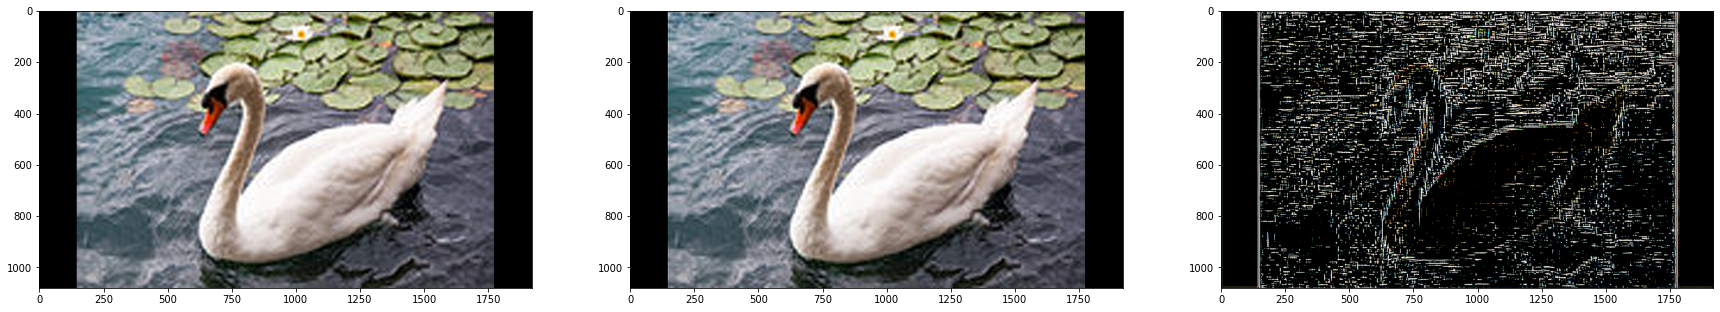

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15))
ax[0].imshow(bicubic_image[:, :, (2, 1, 0)])  # (2,1,0) converts image from BGR to RGB
ax[1].imshow(result[:, :, (2, 1, 0)])
ax[2].imshow(bicubic_image - result)

### Write animated gif with bicubic/superresolution comparison

In [17]:
# Add text with "SUPER" or "BICUBIC" to the superresolution or bicubic image
image_super = write_text_on_image(result, "SUPER")
image_bicubic = write_text_on_image(bicubic_image, "BICUBIC")

# Store the image and the results in IMAGE_DIR
IMAGE_DIR = "images"
os.makedirs(IMAGE_DIR, exist_ok=True)

original_image_path = Path(IMAGE_DIR) / os.path.basename(image_path)
superres_image_path = original_image_path.with_name(f"{original_image_path.stem}_superres{original_image_path.suffix}")
bicubic_image_path = original_image_path.with_name(f"{original_image_path.stem}_bicubic{original_image_path.suffix}")

cv2.imwrite(str(original_image_path), image)
cv2.imwrite(str(superres_image_path), image_super)
cv2.imwrite(str(bicubic_image_path), image_bicubic);

True

In [18]:
result_pil = Image.fromarray(image_super[:, :, (2, 1, 0)])
bicubic_pil = Image.fromarray(image_bicubic[:, :, (2, 1, 0)])

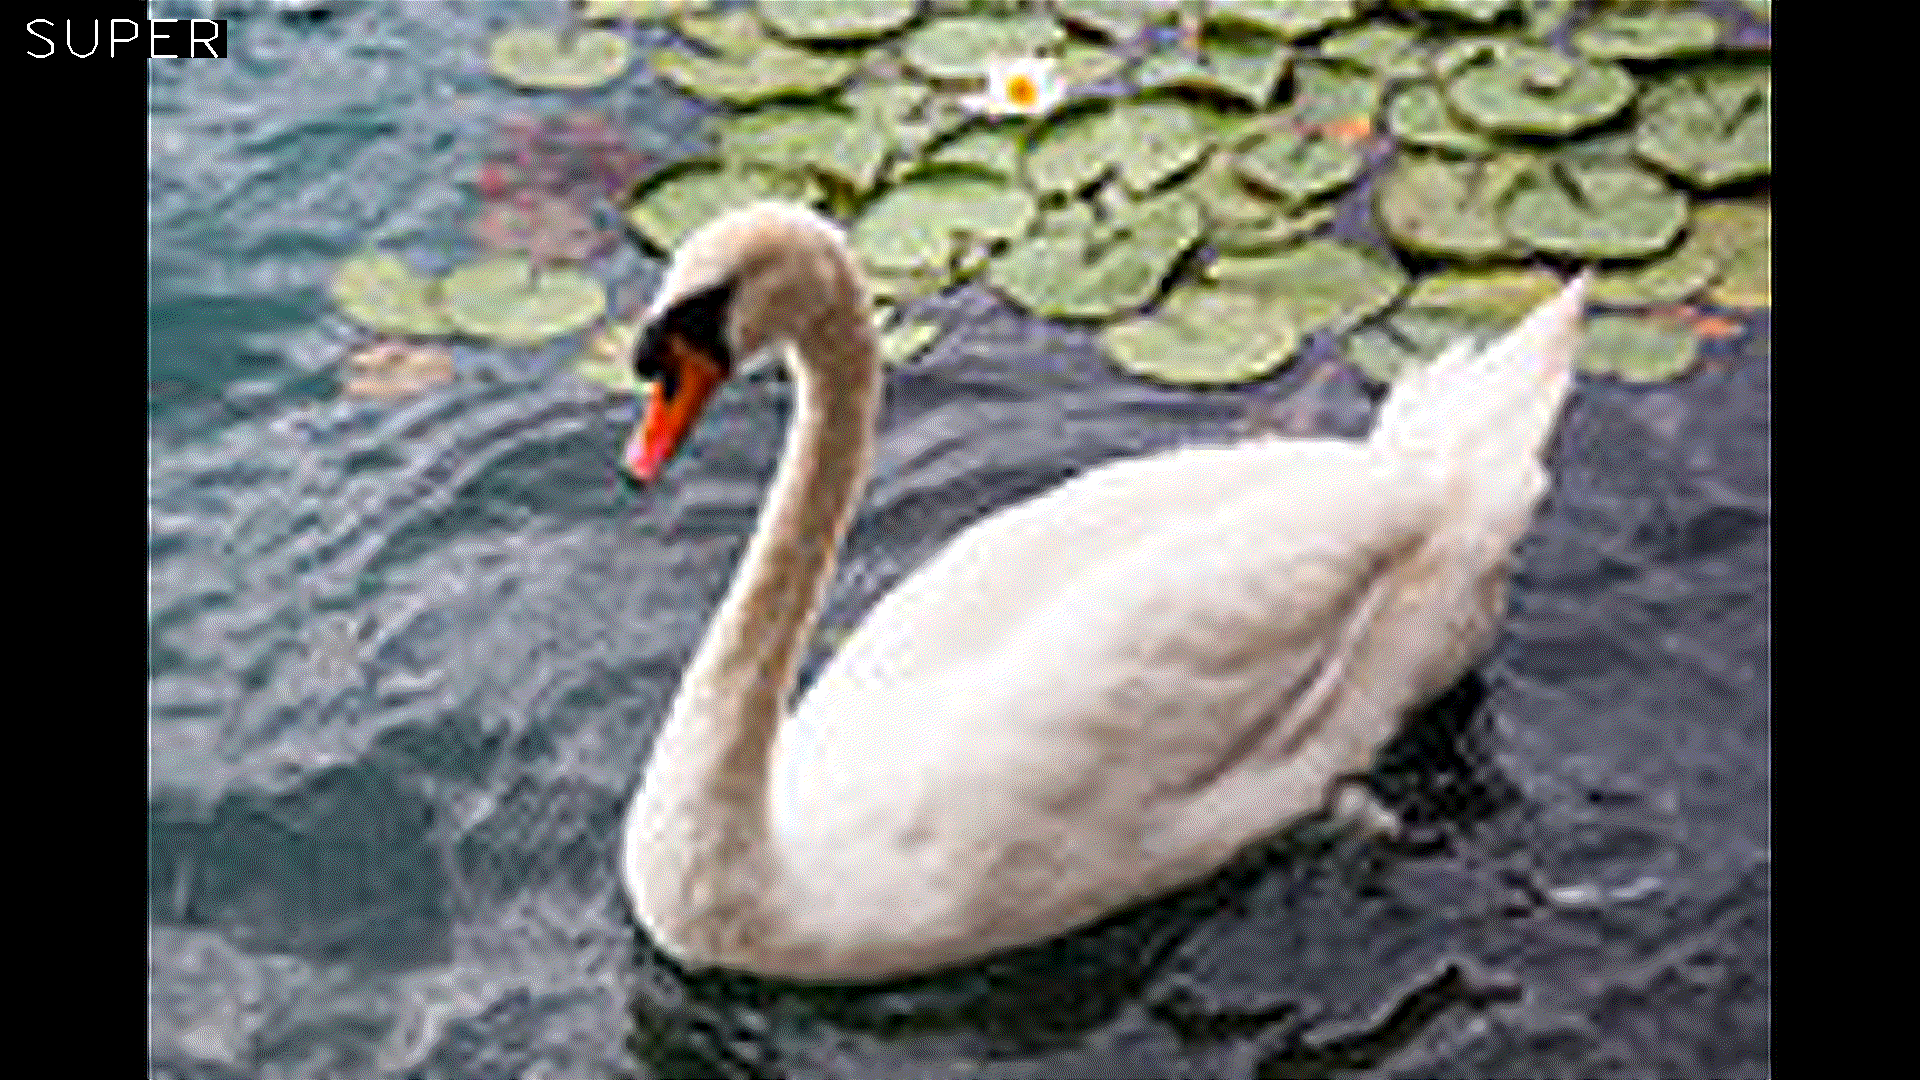

In [19]:
gif_image_path = original_image_path.with_name(f"{original_image_path.stem}_comparison.gif")

result_pil.save(
    fp=str(gif_image_path),
    format="GIF",
    append_images=[
        bicubic_pil,
    ],
    save_all=True,
    duration=1000,
    loop=0,
)
DisplayImage(open(gif_image_path, "rb").read())  # DisplayImage(str(gif_image_path)) doesn't work in Colab

## Superresolution on Video

DEBUG: Uses Youtube_DL for quickly downloading a video from Youtube. 
TODO: save audio to enhanced file

Reads first 1200 frames from video. Change NUM_FRAMES below to modify this.

Settings

In [20]:
VIDEO_DIR = "videos"
VIDEO_NAME = "pat.mp4"
# Number of frames to read from the input video. Set to 0 to read all frames.
NUM_FRAMES = 100

# The format for saving the result video's
# DEBUG: find good format/extension that works well across all platforms
FOURCC = cv2.VideoWriter_fourcc("M", "J", "P", "G")

Download video

In [21]:
video_path = Path(os.path.join(VIDEO_DIR, VIDEO_NAME))

# Use youtube_dl to download a video. It downloads to the videos subdirectory.
# You can also place a local video there and comment out the following lines
VIDEO_URL = "https://www.youtube.com/watch?v=V8yS3WIkOrA"
with youtube_dl.YoutubeDL({"outtmpl": str(video_path)}) as ydl:
    ydl.download([VIDEO_URL])

[youtube] V8yS3WIkOrA: Downloading webpage
[download] Destination: videos/pat.mp4
[download] 100% of 3.93MiB in 00:00


Open the video and read the first frame to get FPS, and frame dimensions, and determine if video is in portrait mode


In [22]:
cap = cv2.VideoCapture(str(video_path))
_, image = cap.read()
FPS = cap.get(cv2.CAP_PROP_FPS)
FRAME_HEIGHT, FRAME_WIDTH = image.shape[:2]
if FRAME_HEIGHT > FRAME_WIDTH:
    PORTRAIT = True
cap.release()

Create superresolution video, bicubic video and comparison video. The superresolution video contains the enhanced video, upsampled with superresolution, the bicubic video is the input video upsampled with bicubic interpolation, the combination video sets the bicubic video and the superresolution side by side.

In [23]:
os.makedirs(VIDEO_DIR, exist_ok=True)
superres_video_path = video_path.with_name(f"{video_path.stem}_superres.avi")
bicubic_video_path = video_path.with_name(f"{video_path.stem}_bicubic.avi")
comparison_video_path = video_path.with_name(f"{video_path.stem}_comparison.avi")

superres_video = cv2.VideoWriter(str(superres_video_path), FOURCC, FPS, (FRAME_WIDTH, FRAME_HEIGHT))
bicubic_video = cv2.VideoWriter(str(bicubic_video_path), FOURCC, FPS, (FRAME_WIDTH, FRAME_HEIGHT))
comparison_video = cv2.VideoWriter(str(comparison_video_path), FOURCC, FPS, (FRAME_WIDTH * 2, FRAME_HEIGHT))

Read all video frames and ENHANCE them. Save the superresolution video, the bicubic video and the comparison video to file


In [24]:
start_time = time.perf_counter()
frame_nr = 0

cap = cv2.VideoCapture(str(video_path))
try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if NUM_FRAMES > 0 and frame_nr == NUM_FRAMES:
            break
        if portrait:
            # resize to landscape
            image = cv2.rotate(image, 2)

        # Resize the image to network input shape
        resized_image = resize_and_pad(image, (input_width, input_height))
        # Reshape the image from (H,W,C) to (N,C,H,W)
        input_image_original = np.expand_dims(resized_image.transpose(2, 0, 1), axis=0)

        # Resize the image to the target shape with bicubic interpolation
        bicubic_image = resize_and_pad(image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
        input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

        # Do inference
        result = exec_net.infer(inputs={original_image_key: input_image_original, bicubic_image_key: input_image_bicubic})[output_key]

        # Transform inference result into frame
        result = convert_result_to_image(result)
        # Write result frame and bicubic frame to video
        superres_video.write(result)
        bicubic_video.write(bicubic_image)
        stacked_frame = np.hstack((bicubic_image, result))
        comparison_video.write(stacked_frame)
        frame_nr = frame_nr + 1

except KeyboardInterrupt:
    print(f"Processing interrupted.")
finally:
    superres_video.release()
    bicubic_video.release()
    comparison_video.release()
    end_time = time.perf_counter()
    duration = end_time - start_time
    print(
        f"Video's saved to {VIDEO_DIR} directory. Processed {frame_nr} frames in {duration:.2f} seconds (Including frame processing and video loading/saving). {frame_nr/duration} frames per second"
    )

Video's saved to videos directory. Processed 100 frames in 57.19 seconds (Including frame processing and video loading/saving). 1.7486741926574971 frames per second


### Show side-by-side video of bicubic and superresolution version

DEBUG Note: this does not work on Google Colab. You can download the comparison video from the VIDEO_DIR directory and play it locally.

In [25]:
video = cv2.VideoCapture(str(comparison_video_path))
display_handle = display(None, display_id=True)
try:
    while cap.isOpened():
        ret, frame = video.read()
        if ret:
            # The line below technically works on colab but it is extremely slow
            # TODO: find a better way to display this
            # display_handle.update(DisplayImage(cv2.imencode(".jpeg", frame)[1].tobytes()))
            display_handle.update(DisplayImage(data=cv2.imencode(".jpeg", frame)[1]))
        else:
            break
except KeyboardInterrupt:
    pass
finally:
    video.release()

None